# Chapter 3 - Deep Q-learning

**Deep Reinforcement Learning __in Action__**

## 2. Q 학습 개요

### 2.6 Gridworld 게임 엔진 소개

#### Listing 3.1  Gridworld 게임 생성

In [1]:
from Gridworld import Gridworld

In [2]:
game = Gridworld(size=4, mode='static')

In [3]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.makeMove('d')

In [5]:
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [6]:
game.makeMove('d')

In [7]:
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', 'P'],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [8]:
game.makeMove('l')

In [9]:
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [10]:
game.reward()

-1

In [11]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [12]:
game.board.render_np().shape

(4, 4, 4)

### 2.7 Q 함수 역할을 하는 신경망

#### Listing 3.2 심층 신경망 Q 함수

In [13]:
import numpy as np
import torch
import random

from Gridworld import Gridworld
import matplotlib.pyplot as plt

In [19]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

In [20]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

#### Listing 3.3 Q 학습 : 주 훈련 루프

In [22]:
epochs = 1000
losses = []  # 손실값들을 담을 목록. 나중에 추세 그래프를 그리는 데 사용한다.

for i in range(epochs):  # 주 훈련 루프
    game = Gridworld(size=4, mode='static')  # 각 훈련 주기에서 새 게임을 시작한다.
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0  # 게임 인스턴스를 생성한 후 상태 정보를 추출해서 약간의 잡음(무작위 요소)을 추가한다.
    state1 = torch.from_numpy(state_).float()  # NumPy 배열을 PyTorch 텐서로 변환해서 새 변수에 설정한다.
    status = 1  # status 변수는 게임이 아직 진행 중인지를 나타낻나.
    
    while status == 1:  # 하나의 게임 에피소드가 끝날 때까지 진행하는 내부 루프이다.
        qval = model(state1)  # Q 신경망의 순전파 단계를 실행해서 모든 동장의 Q 가치를 예측한다.
        qval_ = qval.data.numpy()  # 
        if random.random() < epsilon:  # 엡실론 탐욕법을 이용해서 하나의 동작을 선택한다.
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
            
        action = action_set[action_]  # 선택된 동작의 번호를 Gridworld 게임이 이해하는 동작 문자로 변환한다.
        game.makeMove(action)  # 실제로 동작을 수행한다.
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()  # 게임의 새 상태를 얻는다.
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1, 64))
        maxQ = torch.max(newQ)  # 새 상태로 Q 가치를 얻고 최대 Q 가치를 갱신한다.

        if reward == -1:  # 목표 Q 가치를 계산한다.
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        
        X = qval.squeeze()[action_]  # qval 배열(가치 벡터)의 성분 중 현재 동작에 해당하는 성분만 갱신한 배열을 새 변수에 담는다.
        
        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        
        if reward != -1:  # 보상이 -1 이 아니면 게임이 끝난 것이다(승리 또는 패배)
            status = 0
            
    if epsilon > 0.1:  # 한 에피소드가 끝날 때마다 엡실론을 감소한다.
        epsilon -= (1 / epochs)

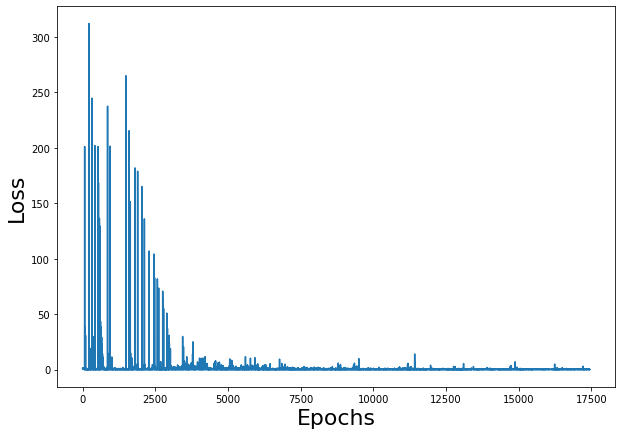

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.show()

##### PyTorch Automatic Differentiation Review

In [24]:
m = torch.Tensor([2.0])
m.requires_grad = True
b = torch.Tensor([1.0])
b.requires_grad = True

def linear_model(x, m, b):
    y = m @ x + b
    return y

In [25]:
y = linear_model(torch.Tensor([4.]), m, b)
y

tensor([9.], grad_fn=<AddBackward0>)

In [26]:
y.grad_fn

In [28]:
with torch.no_grad():
    y = linear_model(torch.Tensor([4.]), m, b)
    
y

tensor([9.])

In [29]:
y.grad_fn

In [30]:
y = linear_model(torch.Tensor([4.]), m, b)

In [31]:
y.backward()

In [33]:
m.grad

tensor([4.])

In [34]:
b.grad

tensor([1.])

#### Listing 3.4  Q 신경망 시험용 함수

In [38]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state = torch.from_numpy(state_).float()
    
    if display:
        print('Initial State:')
        print(test_game.display())
        
    status = 1
    while status == 1:  # 게임이 끝날 때까지 반복한다.
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)  # Q 가치가 가장 높은 동작을 선택한다.
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print('Game won! Reward: %s' % (reward, ))
            else:
                status = 0
                if display:
                    print('Game LOST. Reward: %s' % (reward, ))
                    
        i += 1
        if (i > 15):
            if display:
                print('Game lost; too many moves.')
            break
    win = True if status == 2 else False
    return win

In [39]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [40]:
test_model(model, 'random')

Initial State:
[[' ' 'P' ' ' 'W']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' 'W']
 ['-' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' 'W']
 ['-' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[[' ' ' ' ' ' 'W']
 ['-' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[[' ' ' ' ' ' 'W']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Game LOST. Reward: -10


False

##### Random 모드 학습

In [41]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

In [45]:
from tqdm import tqdm

In [46]:
epochs = 20000
losses = []  # 손실값들을 담을 목록. 나중에 추세 그래프를 그리는 데 사용한다.

for i in tqdm(range(epochs)):  # 주 훈련 루프
    game = Gridworld(size=4, mode='random')  # 각 훈련 주기에서 새 게임을 시작한다.
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0  # 게임 인스턴스를 생성한 후 상태 정보를 추출해서 약간의 잡음(무작위 요소)을 추가한다.
    state1 = torch.from_numpy(state_).float()  # NumPy 배열을 PyTorch 텐서로 변환해서 새 변수에 설정한다.
    status = 1  # status 변수는 게임이 아직 진행 중인지를 나타낻나.
    
    while status == 1:  # 하나의 게임 에피소드가 끝날 때까지 진행하는 내부 루프이다.
        qval = model(state1)  # Q 신경망의 순전파 단계를 실행해서 모든 동장의 Q 가치를 예측한다.
        qval_ = qval.data.numpy()  # 
        if random.random() < epsilon:  # 엡실론 탐욕법을 이용해서 하나의 동작을 선택한다.
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
            
        action = action_set[action_]  # 선택된 동작의 번호를 Gridworld 게임이 이해하는 동작 문자로 변환한다.
        game.makeMove(action)  # 실제로 동작을 수행한다.
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()  # 게임의 새 상태를 얻는다.
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1, 64))
        maxQ = torch.max(newQ)  # 새 상태로 Q 가치를 얻고 최대 Q 가치를 갱신한다.

        if reward == -1:  # 목표 Q 가치를 계산한다.
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        
        X = qval.squeeze()[action_]  # qval 배열(가치 벡터)의 성분 중 현재 동작에 해당하는 성분만 갱신한 배열을 새 변수에 담는다.
        
        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        
        if reward != -1:  # 보상이 -1 이 아니면 게임이 끝난 것이다(승리 또는 패배)
            status = 0
            
    if epsilon > 0.1:  # 한 에피소드가 끝날 때마다 엡실론을 감소한다.
        epsilon -= (1 / epochs)

100%|██████████| 20000/20000 [09:08<00:00, 36.44it/s]


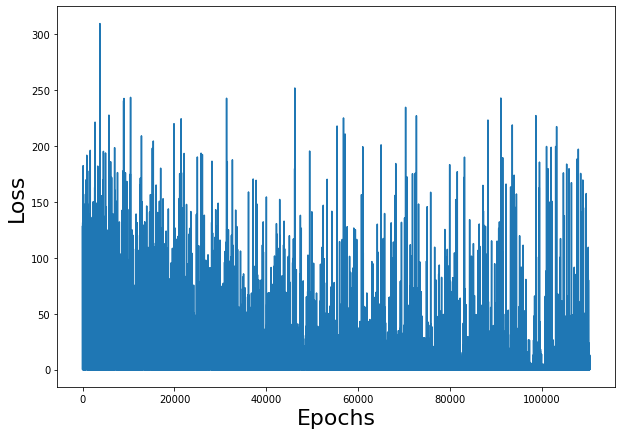

In [47]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.show()

## 3. 파국적 망각 방지: 경험 재현

### 3.2 경험 재현

#### Listing 3.5 경험 재현이 추가된 심층 Q 신경망

In [85]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

In [86]:
from collections import deque
from IPython.display import clear_output

In [87]:
epochs = 5000
losses = []
mem_size = 1000  # 경험 재현 목록의 길이를 설정한다.
batch_size = 200  # 미니배치의 크기를 설정한다.
replay = deque(maxlen=mem_size)  # deque 객체를 경험 재현 목록으로 사용한다.
max_moves = 50  # 게임을 포기하기까지의 최대 이동 횟수를 설정한다.
h = 0

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while status == 1:
        mov += 1
        qval = model(state1)  # 현재 상태의 Q 가치(동작 선택에 사용할)를 계산한다.
        qval_ = qval.data.numpy()
        if random.random() < epsilon:  # 엡실론 탐욕 전략을 이용해서 하나의 동작을 선택한다.
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        action = action_set[action_]
        
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        state2 = torch.from_numpy(state2_).float()
        
        reward = game.reward()
        done = True if reward > 0 else False
        exp = (state1, action_, reward, state2, done)  # 현재 상태, 동작, 보상, 다음 상태를 튜플로 묶는다. 이것이 하나의 '경험' 이다.
        replay.append(exp)  # 경험을 경험 재현 목록에 추가한다.
        state1 = state2
        
        if len(replay) > batch_size:  # 경험 재현 목록이 미니배치 크기보다 크면 미니배치 훈련을 시작한다.
            minibatch = random.sample(replay, batch_size)  # 경험 재현 목록에서 무작위로 하나의 부분집합을 추출한다.
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])  # 경험의 구성 성분들을 종류별로 개별 미니배치 텐서에 넣는다.
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
         
            Q1 = model(state1_batch)  # 현재 상태들의 미니배치로 Q 가치들을 재계산해서 기울기들을 계산한다.
            with torch.no_grad():
                Q2 = model(state2_batch)  # 다음 상태들의 미니배치로 Q 가치들을 재계산하되 기울기들은 계산하지 않는다.
                
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])  # 심층 Q 신경망이 배워야 할 목표 Q 가치들을 계산한다.
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
        if reward != -1 or mov > max_moves:  # 게임이 끝났으면 현재 학습 상태와 이동 횟수를 초기화한다.
            status = 0
            mov = 0

losses = np.array(losses)

4999 0.47424402832984924


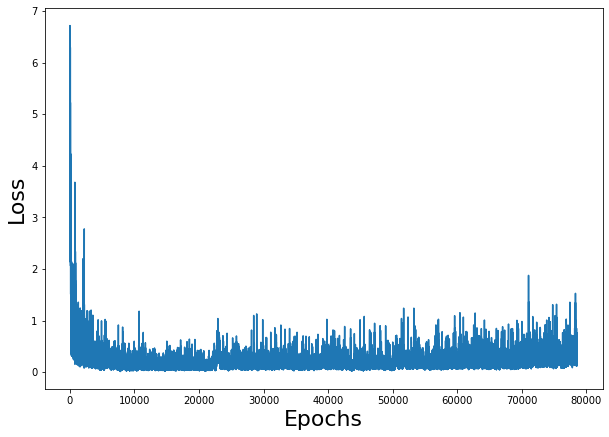

In [88]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.show()

#### Listing 3.6 경험 재현의 성능을 시험하는 스크립트

In [89]:
max_games = 1000
wins = 0
for i in tqdm(range(max_games)):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
    
win_perc = float(wins) / float(max_games)
print('Game played: {0}, # of wins: {1}'.format(max_games, wins))
print('Win percentage: {}'.format(win_perc))

100%|██████████| 1000/1000 [00:00<00:00, 1095.59it/s]

Game played: 1000, # of wins: 499
Win percentage: 0.499


In [92]:
test_model(model, mode='random')

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' '+' ' ' 'P']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' 'W']]
Move #: 0; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' '+' 'P' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' 'W']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' '+' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' 'W']]
Game won! Reward: 10


True

## 4. 목표망을 이용한 안정성 개선

### 4.1 학습 불안정성

#### Listing 3.7  목표망 초기화

In [93]:
import copy

In [95]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4),
)

model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

#### Listing 3.8 경험 재현과 목표망을 이용한 심층 Q 학습 알고리즘

In [105]:
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500  # 목표망 갱신 주기를 설정한다. 주 루프는 훈련 500회마다 model 의 매개변수들을 model2 에 복사한다.
j = 0

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while status == 1:
        j += 1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
            
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
            
            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model2(state2_batch)  # 목표망을 실행해서 다음 상태의 최대 Q 가치를 얻는다.
                
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0:  # 주 Q 신경망의 매개변수들을 목표망에 복사한다.
                model2.load_state_dict(model.state_dict())
                
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
            
losses = np.array(losses)

100%|██████████| 5000/5000 [02:19<00:00, 35.76it/s]


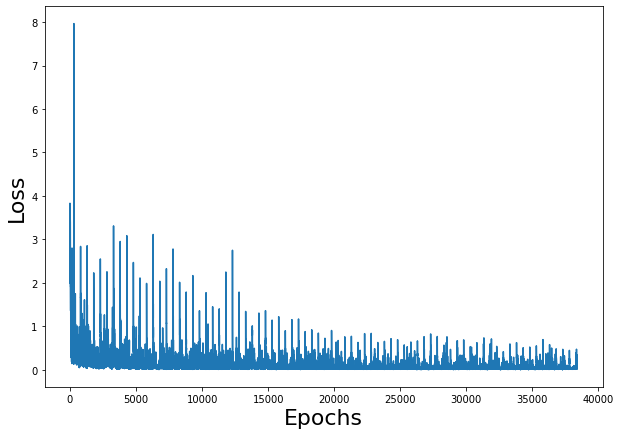

In [106]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.show()

In [135]:
max_games = 1000
wins = 0
for i in tqdm(range(max_games)):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1

win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games, wins))
print('Win percentage: {}%'.format(100.0 * win_perc))

100%|██████████| 1000/1000 [00:00<00:00, 2604.62it/s]

Games played: 1000, # of wins: 922
Win percentage: 92.2%


### Conv + Linear

In [161]:
conv_in1 = 4
conv_in2 = 32
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=conv_in1, out_channels=conv_in2, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=conv_in2, out_channels=l1, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4),
)

model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [162]:
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500  # 목표망 갱신 주기를 설정한다. 주 루프는 훈련 500회마다 model 의 매개변수들을 model2 에 복사한다.
j = 0

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np() + np.random.rand(4, 4, 4) / 100.0
    state1 = torch.from_numpy(state1_).float().unsqueeze(0)
    status = 1
    mov = 0
    while status == 1:
        j += 1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
            
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np() + np.random.rand(4, 4, 4) / 100.0
        state2 = torch.from_numpy(state2_).float().unsqueeze(0)
        reward = game.reward()
        done = True if reward > 0 else False
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
            
            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model2(state2_batch)  # 목표망을 실행해서 다음 상태의 최대 Q 가치를 얻는다.
                
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0:  # 주 Q 신경망의 매개변수들을 목표망에 복사한다.
                model2.load_state_dict(model.state_dict())
                
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
            
    if epsilon > 0.1:  # 한 에피소드가 끝날 때마다 엡실론을 감소한다.
        epsilon -= (1 / epochs)
            
losses = np.array(losses)

4999 0.02081393450498581


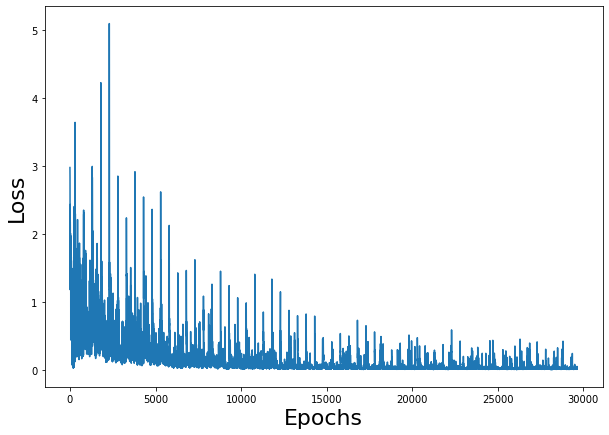

In [163]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.show()

In [164]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np() + np.random.rand(4, 4, 4) / 100.0
    state = torch.from_numpy(state_).float().unsqueeze(0)
    
    if display:
        print('Initial State:')
        print(test_game.display())
        
    status = 1
    while status == 1:  # 게임이 끝날 때까지 반복한다.
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)  # Q 가치가 가장 높은 동작을 선택한다.
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np() + np.random.rand(4, 4, 4) / 100.0
        state = torch.from_numpy(state_).float().unsqueeze(0)
        if display:
            print(test_game.display())
        
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print('Game won! Reward: %s' % (reward, ))
            else:
                status = 0
                if display:
                    print('Game LOST. Reward: %s' % (reward, ))
                    
        i += 1
        if (i > 15):
            if display:
                print('Game lost; too many moves.')
            break
    win = True if status == 2 else False
    return win

In [169]:
max_games = 1000
wins = 0
for i in tqdm(range(max_games)):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print('Games played: {0}, # of wins: {1}'.format(max_games, wins))
print('Win percentage: {}%'.format(100 * win_perc))

100%|██████████| 1000/1000 [00:00<00:00, 1378.33it/s]

Games played: 1000, # of wins: 959
Win percentage: 95.89999999999999%
